In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


# Suppress TensorFlow warnings for clarity
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

print("TensorFlow version:", tf.__version__)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),  # Rotates images by a factor between -10% and +10%
    layers.RandomZoom(0.1),
])

labels_df = pd.read_csv('/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/train_v2.csv')
labels_df.head()

# Print all unique tags
# from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]



TensorFlow version: 2.17.0


In [3]:
train_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/train-jpg/train-jpg'
train_csv_file = '/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/train_v2.csv'
test_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/test-jpg/test-jpg'
test_additional_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/test_v2_file_mapping.csv'
img_resize = (128, 128)  # Desired image size
validation_split = 0.2
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Step 1: Read Labels and File Paths
labels_df = pd.read_csv(train_csv_file)

# Step 2: Extract all unique labels
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))

# Step 3: Create a mapping from label to index
labels_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels_map)

# Step 4: Map Labels to Integers and One-Hot Encode
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)


In [4]:
# Step 5: Split Data into Training and Validation Sets
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(len(train_df), len(val_df))

32383 8096


In [5]:
# Step 6: Define the Pure Python Image Loading Function
def _load_image(path_str):
    """
    Load and preprocess an image from a given file path.

    Args:
        path_str (bytes): The file path as a bytes object.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array.
    """
    try:
        from PIL import Image  # Import inside the function to ensure accessibility

        # Decode the bytes to a UTF-8 string
        path_str = path_str.decode('utf-8')

        # Open the image using PIL
        with Image.open(path_str) as img:
            # Convert image to RGB (handles CMYK and other modes)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(img_resize)
            # Convert to NumPy array and normalize to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0
            # Normalize to [-1, 1]
            img_array = (img_array * 2.0) - 1.0

        return img_array
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        # Return a zero tensor as a placeholder to prevent pipeline failure
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

In [6]:
# Step 7: Define the TensorFlow Wrapper Function using tf.numpy_function
def load_and_preprocess_image_numpy(path, label):
    """
    TensorFlow wrapper for loading and preprocessing an image using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.
        label (tf.Tensor): The corresponding label tensor.

    Returns:
        tuple: A tuple of the preprocessed image tensor and label tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image, label

In [7]:
def augment_image(image, label):
    """
    Apply data augmentation to the image.
    
    Args:
        image (tf.Tensor): The input image tensor.
        label (tf.Tensor): The corresponding label tensor.
    
    Returns:
        tuple: The augmented image tensor and the original label tensor.
    """
    image = data_augmentation(image)
    return image, label

In [8]:
# Step 8: Define the Dataset Creation Function using tf.numpy_function
def create_dataset_numpy(df, training=True):
    """
    Create a TensorFlow dataset from a DataFrame using tf.numpy_function.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        training (bool): Whether the dataset is for training (enables shuffling).

    Returns:
        tf.data.Dataset: The prepared dataset.
    """
    # Construct full file paths
    image_paths = df['image_name'].apply(lambda x: os.path.join(train_jpeg_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)

    # Create a TensorFlow Dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the load_and_preprocess_image_numpy function to the dataset
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)

    if training:
        # Shuffle the dataset for training
        dataset = dataset.shuffle(buffer_size=1000)
        # Apply data augmentation
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch the dataset for optimal performance
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

    return dataset

In [9]:
# Step 9: Create Training and Validation Datasets using tf.numpy_function
train_dataset_numpy = create_dataset_numpy(train_df, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, training=False)

#print(len(train_dataset_numpy),len (val_dataset_numpy))

# Step 10: Verify the Datasets
print("\nVerifying Training Dataset with tf.numpy_function:")
for images, labels in train_dataset_numpy.take(1):
    print("Image tensor shape:", images.shape)
    print("Image tensor dtype:", images.dtype)
    print("Image tensor min value:", tf.reduce_min(images).numpy())
    print("Image tensor max value:", tf.reduce_max(images).numpy())
    print("Image tensor mean value:", tf.reduce_mean(images).numpy())
    break


Verifying Training Dataset with tf.numpy_function:
Image tensor shape: (32, 128, 128, 3)
Image tensor dtype: <dtype: 'float32'>
Image tensor min value: -1.0
Image tensor max value: 0.97626543
Image tensor mean value: -0.35662496


40669
32


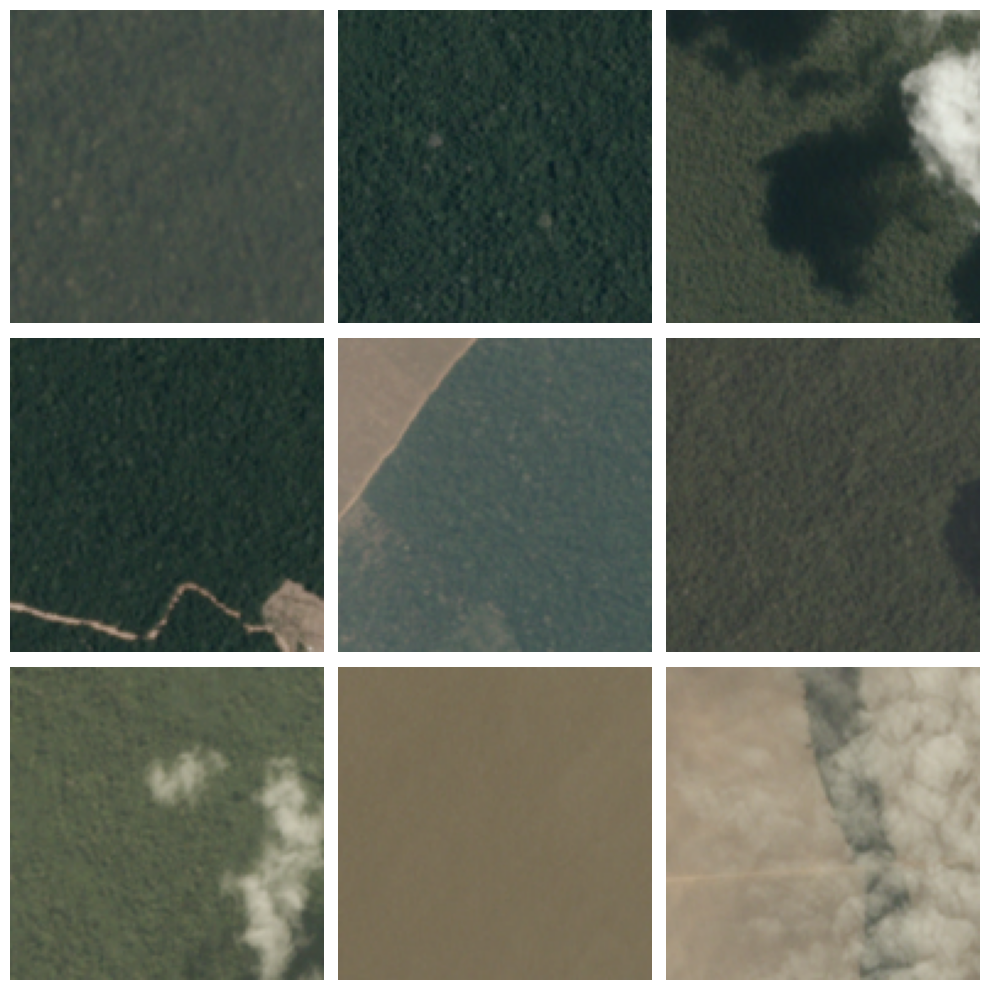

In [11]:
# Step 12: Create Test Dataset using tf.numpy_function and PIL-based Loader
def load_and_preprocess_test_image_numpy(path):
    """
    TensorFlow wrapper for loading and preprocessing test images using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image

# Get test file paths
test_files = [os.path.join(test_jpeg_dir, f) for f in os.listdir(test_jpeg_dir)]

print(len(test_files))

# Create test dataset using the PIL-based loader
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_test_image_numpy, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

# (Optional) Visualize Test Images Without Labels
num_test_images_to_display = 9
plt.figure(figsize=(10, 10))

for images in test_dataset.take(1):
    test_images_np = images.numpy()

    # Convert images from [-1, 1] to [0, 1] for visualization
    test_images_np = (test_images_np + 1.0) / 2.0
    break

print(len(test_images_np))

for i in range(num_test_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images_np[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert dataset into numpy arrays
x_train_data = []
y_train_data = []

x_test_data = []
y_test_data = []

for x_batch, y_batch in train_dataset_numpy:
    x_train_data.append(x_batch.numpy())  # Add images to list
    y_train_data.append(y_batch.numpy())  # Add labels to list

for x_batch, y_batch in val_dataset_numpy:
    x_test_data.append(x_batch.numpy())  # Add images to list
    y_test_data.append(y_batch.numpy())  # Add labels to list

# Concatenate to get all data
x_train_data = np.concatenate(x_train_data, axis=0)
y_train_data = np.concatenate(y_train_data, axis=0)
x_test_data = np.concatenate(x_test_data, axis=0)
y_test_data = np.concatenate(y_test_data, axis=0)

print("All images (x):", x_test_data.shape)
print("All labels (y):", y_test_data.shape)




All images (x): (8096, 128, 128, 3)
All labels (y): (8096, 17)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_resize[0], img_resize[1], 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # Use the number of unique classes
])


model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(x_train_data, y_train_data, epochs=7, batch_size=batch_size, validation_split=0.2)


from sklearn.metrics import classification_report

y_pred_prob = model.predict(x_test_data)

y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold probabilities at 0.5


c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 73s 88ms/step - loss: 0.2257 - val_loss: 0.1724
Epoch 2/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - loss: 0.1589 - val_loss: 0.1511
Epoch 3/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - loss: 0.1421 - val_loss: 0.1434
Epoch 4/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - loss: 0.1330 - val_loss: 0.1446
Epoch 5/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - loss: 0.1228 - val_loss: 0.1330
Epoch 6/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - loss: 0.1135 - val_loss: 0.1322
Epoch 7/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - loss: 0.1068 - val_loss: 0.1333
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


In [18]:
print(classification_report(y_test_data, y_pred, target_names=labels_map))



                   precision    recall  f1-score   support

      agriculture       0.77      0.79      0.78      2441
   artisinal_mine       0.77      0.34      0.48        70
      bare_ground       0.42      0.03      0.05       175
         blooming       0.00      0.00      0.00        64
        blow_down       0.00      0.00      0.00        25
            clear       0.93      0.98      0.96      5728
           cloudy       0.88      0.69      0.77       395
conventional_mine       0.00      0.00      0.00        22
      cultivation       0.60      0.33      0.43       864
       habitation       0.62      0.51      0.56       743
             haze       0.68      0.56      0.62       533
    partly_cloudy       0.94      0.84      0.89      1440
          primary       0.97      0.99      0.98      7507
             road       0.73      0.72      0.72      1568
selective_logging       0.38      0.05      0.09        61
       slash_burn       0.00      0.00      0.00       

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
thresholds = [0.5, 0.15, 0.3, 0.15, 0.15, .5, .2, .03, .25, .45, .25, .4, .5, .5, .1, .06, .35]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)
print(classification_report(y_test_data, predicted_classes, target_names=labels_map))

i= 0
tru = 0
key = list(labels_map.keys())[i]

while True:
    if (y_test_data[i][0] != predicted_classes[i][0]):
        print(y_test_data[i], predicted_classes[i])
        tru+=1
        if (tru > 5):
            break
    i+=1

                   precision    recall  f1-score   support

      agriculture       0.77      0.79      0.78      2441
   artisinal_mine       0.55      0.51      0.53        70
      bare_ground       0.27      0.09      0.14       175
         blooming       0.12      0.08      0.10        64
        blow_down       0.00      0.00      0.00        25
            clear       0.93      0.98      0.96      5728
           cloudy       0.79      0.85      0.82       395
conventional_mine       0.14      0.41      0.21        22
      cultivation       0.42      0.53      0.47       864
       habitation       0.58      0.54      0.56       743
             haze       0.56      0.71      0.63       533
    partly_cloudy       0.92      0.86      0.89      1440
          primary       0.97      0.99      0.98      7507
             road       0.73      0.72      0.72      1568
selective_logging       0.15      0.18      0.17        61
       slash_burn       0.07      0.02      0.03       

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


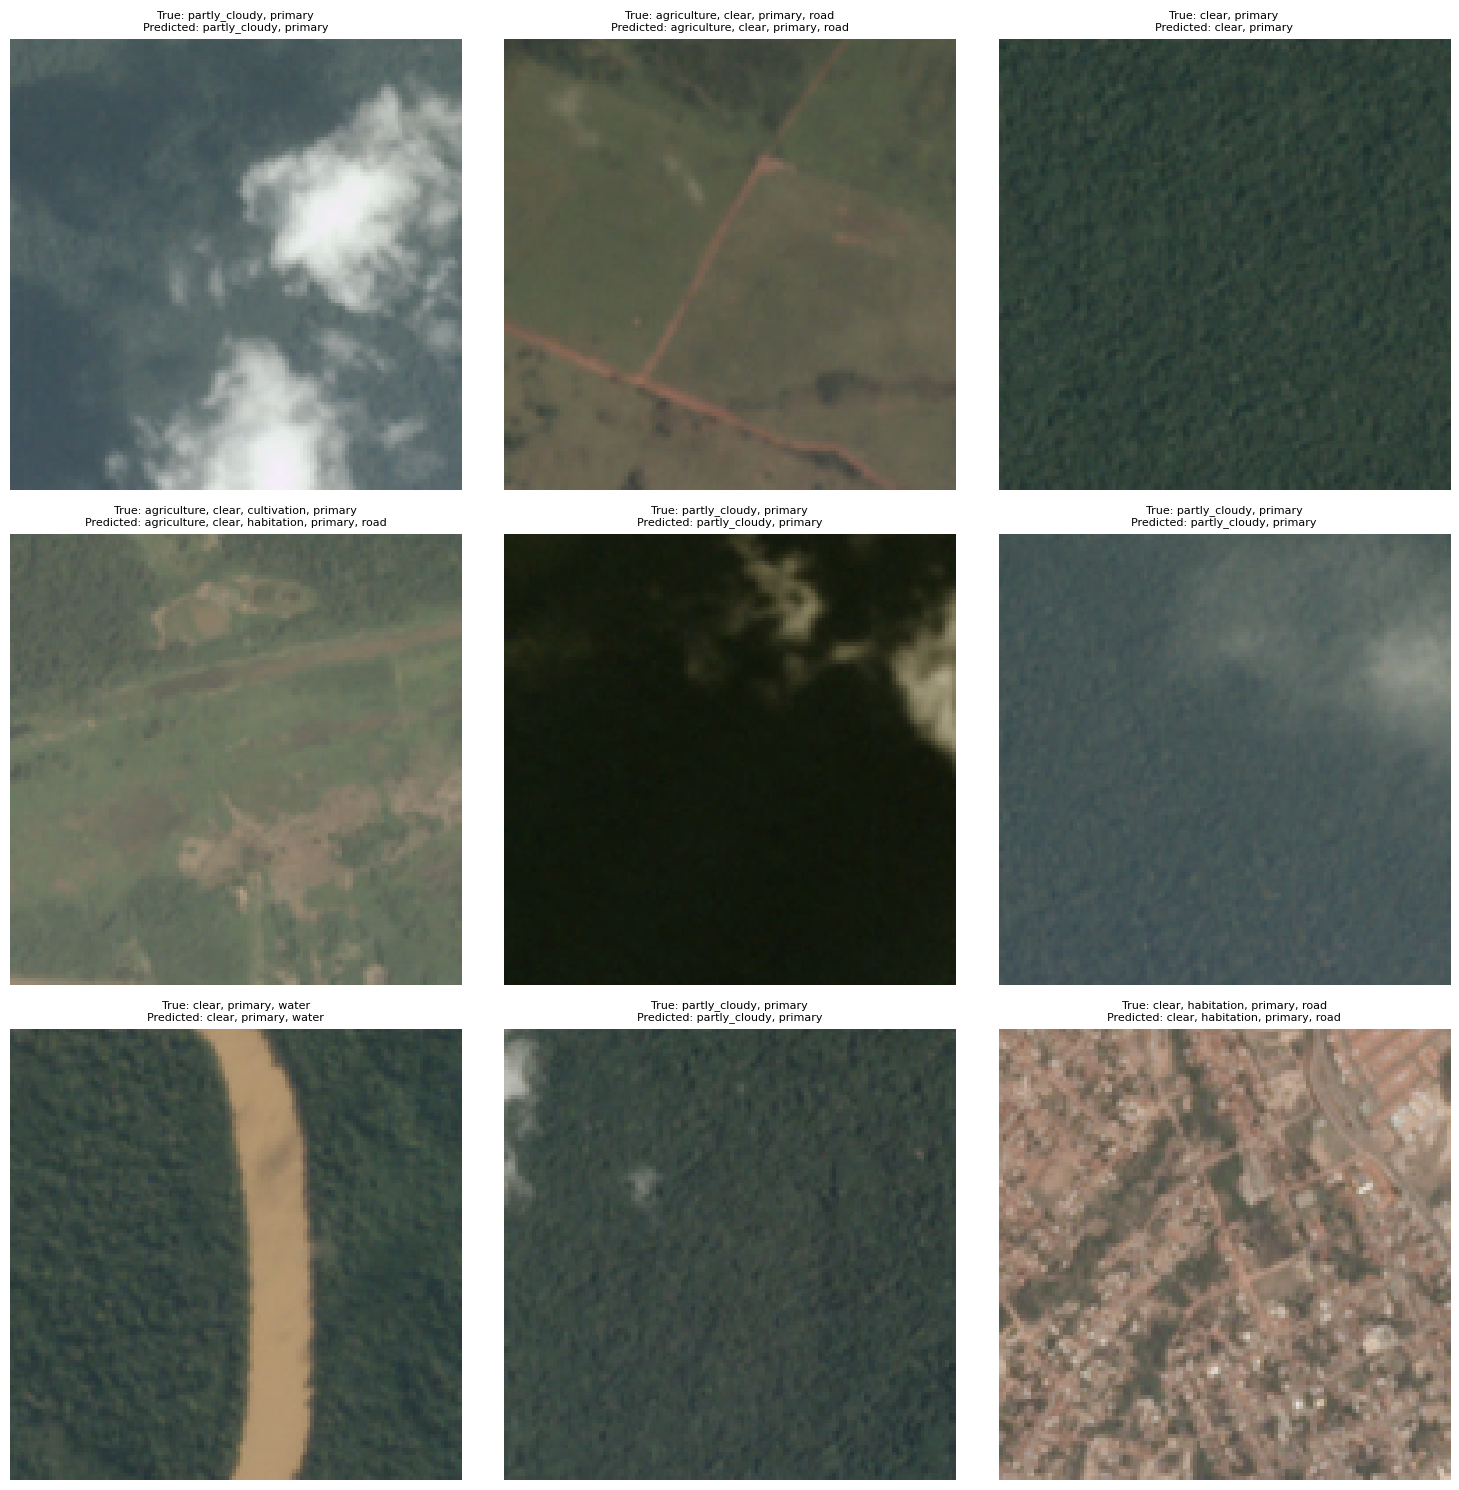

In [16]:
# Get a batch of validation data
for images, true_labels in val_dataset_numpy.skip(12).take(1):
    predictions = model.predict(images)  # Predict probabilities for the batch

    # Decode predictions into binary labels (using threshold = 0.5)
    predicted_labels = (predictions > 0.5).astype(int)

    # Plot the images with predictions
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2.0)  # Denormalize image to [0, 1]
        plt.axis('off')
        true_label_text = ", ".join([label for label, present in zip(labels_map.keys(), true_labels[i]) if present])
        predicted_label_text = ", ".join([label for label, present in zip(labels_map.keys(), predicted_labels[i]) if present])
        plt.title(f"True: {true_label_text}\nPredicted: {predicted_label_text}", fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
vgg_model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_resize[0], img_resize[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer for Multi-Class Classification
    layers.Dense(num_classes, activation='sigmoid')
])

vgg_model.compile(optimizer='adam', loss='binary_crossentropy')
vgg_model.fit(x_train_data, y_train_data, epochs=5, batch_size=batch_size, validation_split=0.2)

y_pred_prob = vgg_model.predict(x_test_data)


Epoch 1/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 727s 891ms/step - loss: 0.2721 - val_loss: 0.1773
Epoch 2/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 580s 716ms/step - loss: 0.1781 - val_loss: 0.1677
Epoch 3/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 592s 731ms/step - loss: 0.1657 - val_loss: 0.1611
Epoch 4/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 628s 775ms/step - loss: 0.1578 - val_loss: 0.1599
Epoch 5/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 696s 860ms/step - loss: 0.1535 - val_loss: 0.1582
253/253 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step


In [28]:
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold probabilities at 0.5
print(classification_report(y_test_data, y_pred, target_names=labels_map))

vgg_thresholds = [0.5, 0.15, 0.3, 0.15, 0.15, .5, .2, .03, .25, .45, .25, .4, .5, .5, .1, .06, .35]  # Custom threshold for each class
vgg_predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)
print(classification_report(y_test_data, vgg_predicted_classes, target_names=labels_map))

                   precision    recall  f1-score   support

      agriculture       0.75      0.67      0.71      2441
   artisinal_mine       0.00      0.00      0.00        70
      bare_ground       0.00      0.00      0.00       175
         blooming       0.00      0.00      0.00        64
        blow_down       0.00      0.00      0.00        25
            clear       0.94      0.95      0.94      5728
           cloudy       0.61      0.80      0.69       395
conventional_mine       0.00      0.00      0.00        22
      cultivation       0.71      0.02      0.04       864
       habitation       0.62      0.28      0.38       743
             haze       0.70      0.36      0.48       533
    partly_cloudy       0.89      0.77      0.82      1440
          primary       0.97      0.97      0.97      7507
             road       0.65      0.61      0.63      1568
selective_logging       0.00      0.00      0.00        61
       slash_burn       0.00      0.00      0.00       

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'agriculture': {'precision': 0.7930310663308144, 'recall': 0.7738631708316264, 'f1-score': 0.7833298776695004, 'support': 2441.0}, 'artisinal_mine': {'precision': 0.41935483870967744, 'recall': 0.5571428571428572, 'f1-score': 0.4785276073619632, 'support': 70.0}, 'bare_ground': {'precision': 0.2748091603053435, 'recall': 0.2057142857142857, 'f1-score': 0.23529411764705882, 'support': 175.0}, 'blooming': {'precision': 0.05935483870967742, 'recall': 0.71875, 'f1-score': 0.10965435041716329, 'support': 64.0}, 'blow_down': {'precision': 0.3333333333333333, 'recall': 0.04, 'f1-score': 0.07142857142857142, 'support': 25.0}, 'clear': {'precision': 0.9430209035738368, 'recall': 0.9766061452513967, 'f1-score': 0.9595197255574615, 'support': 5728.0}, 'cloudy': {'precision': 0.6813819577735125, 'recall': 0.8987341772151899, 'f1-score': 0.7751091703056768, 'support': 395.0}, 'conventional_mine': {'precision': 0.06329113924050633, 'recall': 0.6818181818181818, 'f1-score': 0.11583011583011583, 'sup

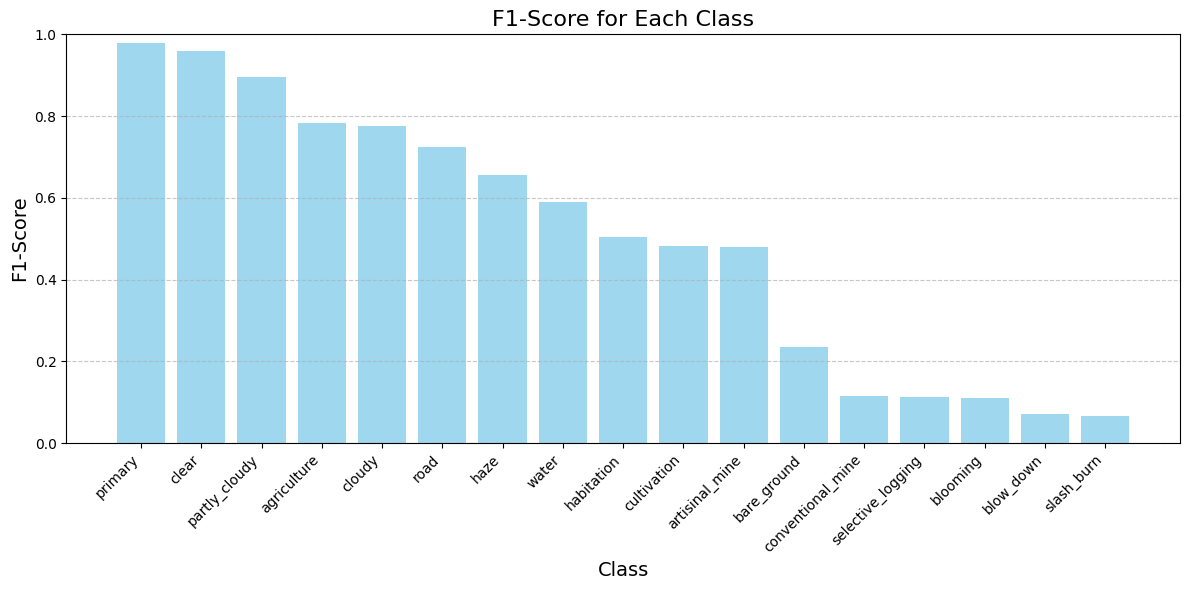

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Example classification report (dictionary format or generated from sklearn)
report = classification_report(y_test_data, predicted_classes, target_names=labels_map, output_dict=True)
print(report)
class_f1_scores = {
    k: v["f1-score"] for k, v in report.items() if k not in ["micro avg", "macro avg", "weighted avg", "samples avg"]
}

sorted_scores = sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)  # Sort by F1 score descending
classes, f1_scores = zip(*sorted_scores)


plt.figure(figsize=(12, 6))
plt.bar(classes, f1_scores, color="skyblue", alpha=0.8)
plt.title("F1-Score for Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0, 1)  # F1-scores range between 0 and 1
plt.xticks(rotation=45, ha="right")  # Rotate class names for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
